Citation:


https://colab.research.google.com/github/Rakshit-Shetty/Resnet-Implementation/blob/master/ResNet_Implementation_on_CIFAR10.ipynb

Reference:
https://github.com/kuangliu/pytorch-cifar?tab=readme-ov-file
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Deep Residual Learning for Image Recognition. arXiv:1512.03385



# CIFAR10 Images Classification with Resnet-18

## Library Import

In [68]:
!pip install typed-argument-parser

In [69]:
!pip install wandb

In [123]:
import csv
import os
import math
import time
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision.transforms as transforms
from torchvision.transforms import v2, InterpolationMode
from torch.utils.data import DataLoader,Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torch import Tensor
from sklearn.metrics import confusion_matrix
from typing import Callable, List, Optional, Type, Union
import wandb

import matplotlib.pyplot as plt
from tap import Tap
from PIL import Image


# Define ResNet Structure

In [71]:
def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(
        in_planes,
        out_planes,
        kernel_size=3,
        stride=stride,
        padding=dilation,
        groups=groups,
        bias=False,
        dilation=dilation,
    )


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError("BasicBlock only supports groups=1 and base_width=64")
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition" https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.0)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        channels: List[int] = [64, 128, 256, 512],
        num_classes: int = 10,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None,
    ) -> None:
        super().__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = channels[0]
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError(
                "replace_stride_with_dilation should be None "
                f"or a 3-element tuple, got {replace_stride_with_dilation}"
            )
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        # self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, channels[0], layers[0])
        self.layer2 = self._make_layer(block, channels[1], layers[1], stride=2, dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, channels[2], layers[2], stride=2, dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, channels[3], layers[3], stride=2, dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(channels[-1] * block.expansion, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode="fan_out", nonlinearity="relu")
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck) and m.bn3.weight is not None:
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock) and m.bn2.weight is not None:
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        planes: int,
        blocks: int,
        stride: int = 1,
        dilate: bool = False,
    ) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(
            block(
                self.inplanes, planes, stride, downsample, self.groups, self.base_width, previous_dilation, norm_layer
            )
        )
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(
                block(
                    self.inplanes,
                    planes,
                    groups=self.groups,
                    base_width=self.base_width,
                    dilation=self.dilation,
                    norm_layer=norm_layer,
                )
            )

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        # x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)

# Argument Parser

In [94]:
class ArgsParser(Tap):
    # hyperparameters
    lr: float = 0.01
    momentum: float = 0.9
    weight_decay: float = 0.001 # Original 0.0001
    n_epochs: int = 2
    start_epoch: int = 0
    batch_size: int = 512
    num_workers: int = 0
    valid_size: float = 0.2
    optimizer: str = "adamw" # Optimizer type: adamw, sgd, adam
    self_supervise: bool = False # Self supervise: True, False
        
    # data paths
    test_data_path: str = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/test_batch'
    test_nolabel_path: str = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl'
    data_dir: str = '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py'
    
    # architectural modifications
    model_arch: str = 'custom'
    stride: int = 1  
    in_planes: int = 64  
    num_channels: str = "32,64,128,256"  # original [64,128,256,512]
    filter_sizes: str = "3,3,3,3" 
    num_blocks: str = "2,2,2,2"
        
    # kernel_sizes: list = [1, 1, 1, 1]  # Kernel sizes for skip connections
    # avgpool_size: int = 4  # Pool size for the average pool layer

    def configure(self):
        self.description = 'Argument parser for training different ResNet models on CIFAR-10'

    def process_args(self):
        self.num_blocks = list(map(int, self.num_blocks.split(',')))
        self.num_channels = list(map(int, self.num_channels.split(',')))
        self.filter_sizes = list(map(int, self.filter_sizes.split(',')))


In [73]:
def get_resnet_model(arch: str):
    if arch == 'resnet18':
        return ResNet(BasicBlock, [2, 2, 2, 2])
    elif arch == 'resnet34':
        return ResNet(BasicBlock, [3, 4, 6, 3])
    elif arch == 'custom':
        return ResNet(BasicBlock, args.num_blocks, args.num_channels)
    else:
        raise ValueError(f'Unknown architecture: {arch}')

def get_optimizer(optimizer:str):
    if optimizer.lower() == 'sgd':
        return optim.SGD(net.parameters(), lr=args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
    elif optimizer.lower() == 'adam':
        return optim.Adam(net.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    elif optimizer.lower() == 'adamw':
        return optim.AdamW(net.parameters(), lr=args.lr, weight_decay=args.weight_decay)
    else:
        raise ValueError(f'Unsupported optimizer: {optimizer}')

In [95]:
args = ArgsParser().parse_args(args=[]) # Parse the arguments

# Weight & Bias Initialization

In [96]:
def initialize_wandb(args: ArgsParser):
    wandb.init(project='NYUcifarChallenge', entity='eustinalwq', config=args.as_dict())
    wandb.config = {
        "learning_rate": args.lr,
        "epochs": args.n_epochs,
        "batch_size": args.batch_size,
        "model_architecture": args.model_arch,
        "optimizer": args.optimizer,
    }
    print("Args: ", args)

In [97]:
initialize_wandb(args) # Initialize wandb

epoch,▁█▁█
lr,▅▁▅█
train_loss,█▆▅▅▅▄▅▄▄▄▄▄▃▃▂▂▂▃▂▂▂▃▂▂▂▂▃▂▂▃▂▂▂▂▂▁▂▂▂▁
valid_loss,█▇█▇████▆█▅▅▆▄▅▆▅▆▅▄▄▄▅▆▄▅▄▄▄▄▁▂▃▁▂▂▃▁▃▃
epoch,2
lr,0.01
train_loss,0.96991
valid_loss,1.00655


Args:  {'batch_size': 512,
 'data_dir': '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py',
 'filter_sizes': [3, 3, 3, 3],
 'in_planes': 64,
 'lr': 0.01,
 'model_arch': 'custom',
 'momentum': 0.9,
 'n_epochs': 2,
 'num_blocks': [2, 2, 2, 2],
 'num_channels': [32, 64, 128, 256],
 'num_workers': 0,
 'optimizer': 'adamw',
 'self_supervise': False,
 'start_epoch': 0,
 'stride': 1,
 'test_data_path': '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar-10-python/cifar-10-batches-py/test_batch',
 'test_nolabel_path': '/kaggle/input/deep-learning-mini-project-spring-24-nyu/cifar_test_nolabels.pkl',
 'valid_size': 0.2,
 'weight_decay': 0.001}


# Check Cuda

In [98]:
def check_cuda():
    # check if CUDA is available
    train_on_gpu = torch.cuda.is_available()
    if not train_on_gpu:
        print('CUDA is not available.  Training on CPU')
        device = torch.device("cpu")
    else:
        print('CUDA is available!  Training on GPU')
        device = torch.device("cuda")
    return train_on_gpu, device

In [99]:
train_on_gpu, device = check_cuda() # Check if CUDA is available

CUDA is available!  Training on GPU


# Data Loader

In [100]:
# Function to load a single batch file
def load_cifar_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict[b'labels']
        X = X.reshape(10000, 3, 32, 32).astype("float")
        Y = np.array(Y)
        return X, Y


# Function to load the test batch without labels
def load_cifar_test_nolabels(filename):
    with open(filename, 'rb') as f:
        try:
            datadict = pickle.load(f, encoding='bytes')
            # print("Data dictionary keys:", datadict.keys())  # To check the structure of the dictionary
            # Access the correct key for the data
            X = datadict[b'data']
            X = X.reshape(-1, 3, 32, 32).astype('float32')  # Adjust shape accordingly if needed
            return X
        except EOFError as e:
            print("EOFError while unpickling the file:", e)
        except Exception as e:
            print("An error occurred:", e)

# Function to load the test batch
def load_cifar_test_batch(filename):
    with open(filename, 'rb') as f:
        datadict = pickle.load(f, encoding='bytes')
        X = datadict[b'data']
        Y = datadict.get(b'labels', None)  # Try to get the labels if they exist
        X = X.reshape(-1, 3, 32, 32).astype("float32")  # Reshape and convert data type
        return X, Y
    
# Class to load dataset
class CIFAR10Dataset(Dataset):
    def __init__(self, data, targets=None, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        """
        Returns one sample at a time
        """
        if index >= len(self.data):
            raise IndexError(f'Requested index {index} exceeds dataset length {len(self.data)}.')
        # Select sample
        image = self.data[index]

        # Convert image from numpy array to PIL Image to apply transform
        image = Image.fromarray(image.astype('uint8').transpose((1, 2, 0)))

        # Apply the given transform
        if self.transform:
            image = self.transform(image)

        # Return image and the corresponding label if available
        if self.targets is not None:
            target = self.targets[index]
            return image, target
        else:
            return image


In [101]:
data_dir = args.data_dir
batch_files = [os.path.join(data_dir, 'data_batch_{}'.format(i)) for i in range(1, 6)]
data_batches = [load_cifar_batch(batch_file) for batch_file in batch_files]
train_data = np.vstack([batch[0] for batch in data_batches])
train_labels = np.hstack([batch[1] for batch in data_batches])
# number of subprocesses to use for data loading
num_workers = args.num_workers
batch_size = args.batch_size
valid_size = args.valid_size
# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
# Generate new validation indices starting from 0
valid_idx = list(range(0, split))
# Make sure the new indices are within the bounds
assert min(valid_idx) >= 0 and max(valid_idx) < 10000, "Valid indices are out of bounds."
# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# Data Augmentation

In [102]:
# Define transforms
transform_train  = v2.Compose([
    v2.RandomResizedCrop(32, scale=(0.85, 1.0), interpolation=InterpolationMode.BICUBIC),
    v2.RandomApply(
        nn.ModuleList([
            v2.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1)
        ]),
        p=0.3
    ),
    v2.RandomAutocontrast(p=0.2),
    v2.RandomGrayscale(p=0.2),
    v2.RandomHorizontalFlip(p=0.5),
    v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)]),
    v2.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
# Create dataset objects
train_dataset = CIFAR10Dataset(train_data, train_labels, transform=transform_train)
valid_dataset = CIFAR10Dataset(train_data[valid_idx], train_labels[valid_idx], transform=transform_test)
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers, drop_last=True)
# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog', 'frog', 'horse', 'ship', 'truck']

## Visualization of dataset

In [103]:
def imshow(img):
    # helper function to un-normalize and display an image
    img = img / 2 + 0.5  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

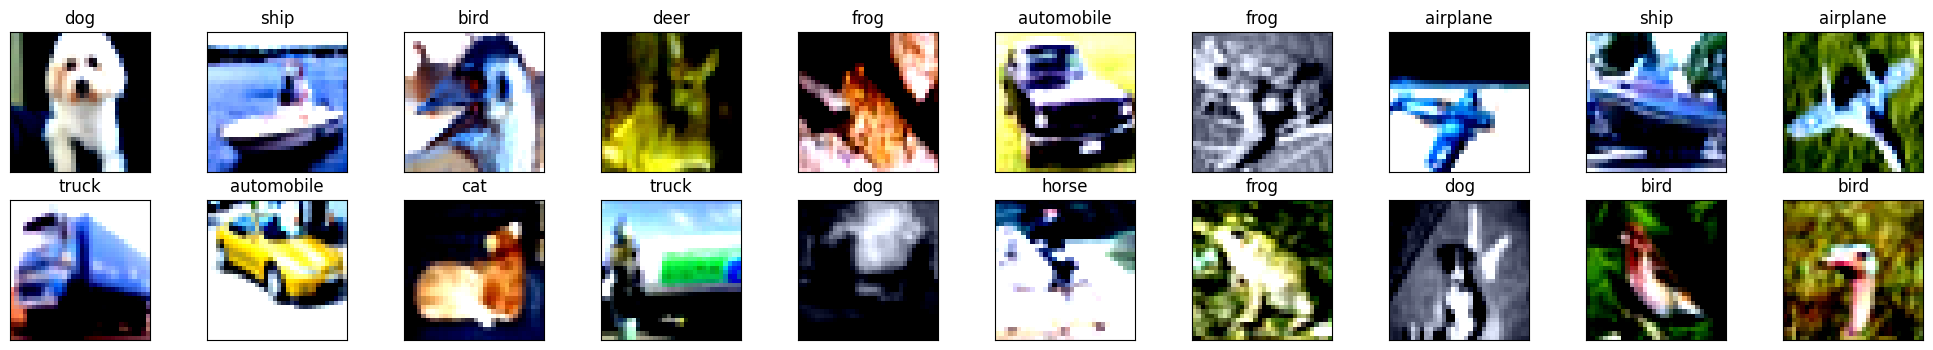

In [104]:
# obtain one batch of training images
dataiter = iter(train_loader)
# images, labels = dataiter.next()
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

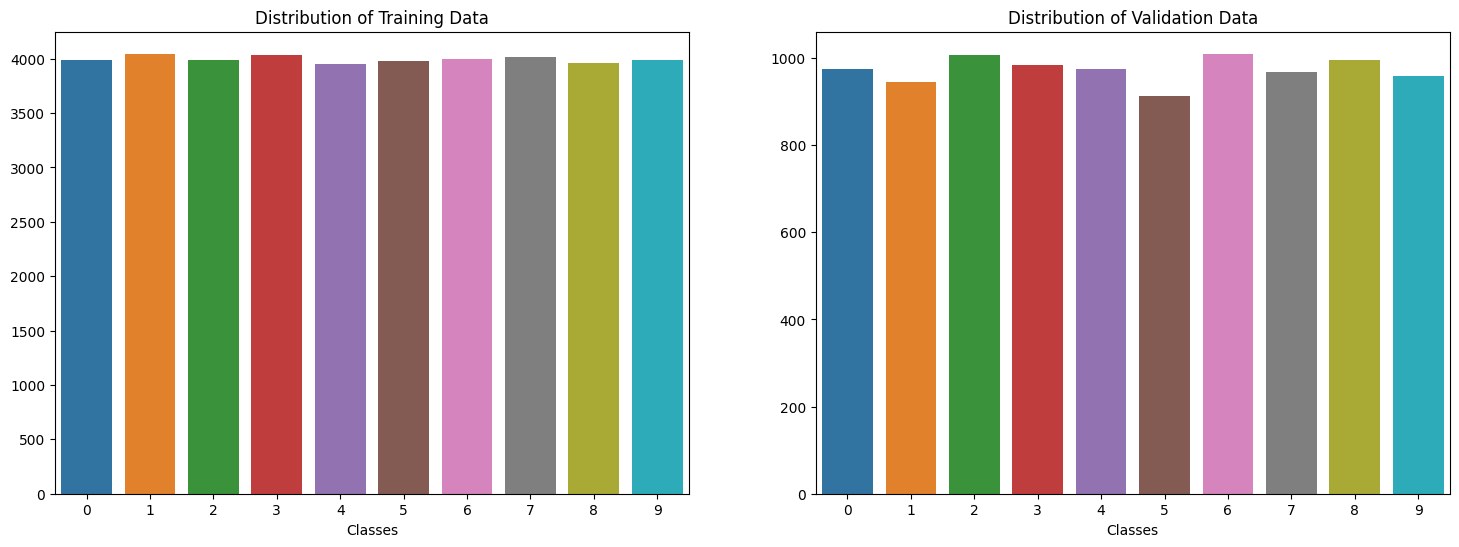

In [105]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter

# Function to extract labels from a DataLoader
def get_labels(dataloader):
    labels = []
    for _, label in dataloader:
        labels.extend(label.numpy()) # Assuming label is a tensor, if not, just extend label
    return labels

# Extract labels
train_labels = get_labels(train_loader)
valid_labels = get_labels(valid_loader)

# Count occurrences
train_label_counts = Counter(train_labels)
valid_label_counts = Counter(valid_labels)

# Convert to lists or pandas Series/DataFrame for plotting
train_counts = pd.Series(train_label_counts)
valid_counts = pd.Series(valid_label_counts)

# Plot
figure, axis = plt.subplots(1, 2, figsize=(18,6))
sns.barplot(x=train_counts.index, y=train_counts.values, ax=axis[0])
axis[0].set_title('Distribution of Training Data')
axis[0].set_xlabel('Classes')

sns.barplot(x=valid_counts.index, y=valid_counts.values, ax=axis[1])
axis[1].set_title('Distribution of Validation Data')
axis[1].set_xlabel('Classes')

plt.show()


# Model Define

In [106]:
def count_all_parameters(model):
    # count parameter include non-trainable
    return sum(p.numel() for p in model.parameters())

def count_parameters(model):
    # count parameter exclude non-trainable
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [107]:
start_epoch = args.start_epoch  # start from epoch 0 or last checkpoint epoch
print('==> Building model..')

# define model according to args definition
net = get_resnet_model(args.model_arch)
net = net.to(device)

total_params = count_all_parameters(net)
print(f"The model has {total_params:,} total parameters, including non-trainable ones.")

# Now count the parameters:
total_params = count_parameters(net)
print(f"The model has {total_params:,} trainable parameters.")

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

==> Building model..
The model has 2,797,610 total parameters, including non-trainable ones.
The model has 2,797,610 trainable parameters.


In [108]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = get_optimizer(args.optimizer)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.n_epochs)

## Train

In [109]:
def trainer(args, train_on_gpu, train_loader, valid_loader, net, criterion, optimizer, scheduler):
    """### Training Start"""
    # number of epochs to train the model
    n_epochs = args.n_epochs
    valid_loss_min = np.Inf # track change in validation loss
    train_losses = []
    valid_losses = []

    for epoch in range(1, n_epochs+1):
        # keep track of training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        ###################
        # train the model #
        ###################
        net.train()
        for batch_idx, (data, target) in enumerate(train_loader):
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            wandb.log({"train_loss": loss.item()})
        ######################
        # validate the model #
        ######################
        net.eval()
        for batch_idx, (data, target) in enumerate(valid_loader):
            if train_on_gpu:
              data, target = data.cuda(), target.cuda()
            output = net(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
            wandb.log({"valid_loss": loss.item()})
        # calculate average losses
        train_loss = train_loss/len(train_loader.sampler)
        valid_loss = valid_loss/len(valid_loader.sampler)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        # Update learning rate with scheduler
        scheduler.step()
        # Optional: Log learning rate to wandb or print it out
        current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch {epoch}: Current learning rate: {current_lr}")
        wandb.log({'epoch': epoch, 'lr': current_lr})

        # print training/validation statistics
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    # save model if validation loss has decreased
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
            torch.save(net.state_dict(), 'ResNet18.pt')
            wandb.save('ResNet18.pt')
            valid_loss_min = valid_loss

    net.load_state_dict(torch.load('ResNet18.pt'))
    return train_losses,valid_losses

In [110]:
train_losses,valid_losses = trainer(args, train_on_gpu, train_loader, valid_loader, net, criterion, optimizer, scheduler)

Epoch 1: Current learning rate: 0.005
Epoch: 1 	Training Loss: 1.955803 	Validation Loss: 1.719820
Validation loss decreased (inf --> 1.719820).  Saving model ...
Epoch 2: Current learning rate: 0.0
Epoch: 2 	Training Loss: 1.558738 	Validation Loss: 1.393384
Validation loss decreased (1.719820 --> 1.393384).  Saving model ...


## Train Validation Loss Graph

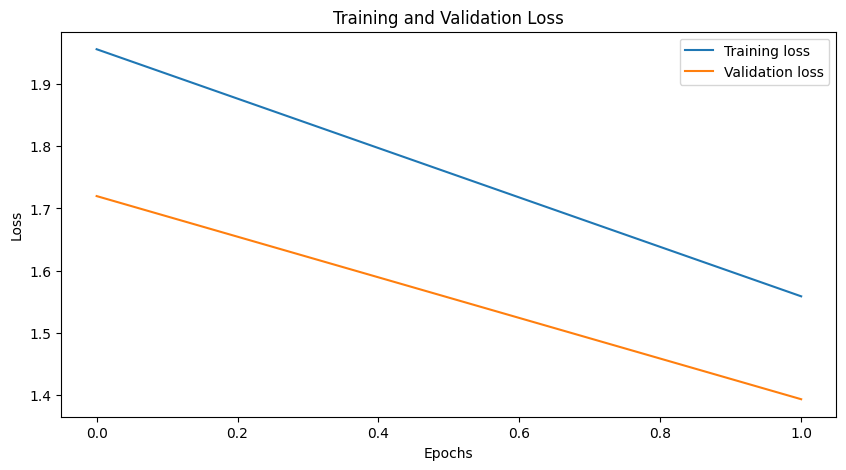

In [112]:
# Plotting
plt.figure(figsize=(10,5))
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Test on test batch

# Tester with confusion matrix

In [126]:
def tester_withlabel(args, train_on_gpu, num_workers, batch_size, transform_test, classes, net, criterion):
    # Load the test data
    test_data, test_labels = load_cifar_test_batch(args.test_data_path)
    test_dataset = CIFAR10Dataset(test_data, test_labels, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

    net.eval()

    # Initialize the confusion matrix
    num_classes = 10
    confusion_matrix = np.zeros((num_classes, num_classes), dtype=np.int64)

    test_loss = 0.0

    # Iterate over test data
    for batch_idx, (data, target) in enumerate(test_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        # Forward pass
        output = net(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)

        # Get predictions
        _, preds = torch.max(output, 1)
        correct = preds.eq(target.data.view_as(preds))

        # Update confusion matrix
        for t, p in zip(target.view(-1), preds.view(-1)):
            confusion_matrix[t.long(), p.long()] += 1

    # Average test loss
    test_loss /= len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.6f}\n')

    # Print accuracy for each class
    for i in range(num_classes):
        if confusion_matrix[i].sum() > 0:
            print(f'Test Accuracy of {classes[i]}: {100 * np.diag(confusion_matrix)[i] / np.sum(confusion_matrix[i]):2.0f}% ({np.diag(confusion_matrix)[i]}/{np.sum(confusion_matrix[i])})')
        else:
            print(f'Test Accuracy of {classes[i]}: N/A (no training examples)')

    # Overall accuracy
    overall_accuracy = 100. * np.trace(confusion_matrix) / np.sum(confusion_matrix)
    print(f'\nTest Accuracy (Overall): {overall_accuracy:.2f}% ({np.trace(confusion_matrix)}/{np.sum(confusion_matrix)})')

    # Optionally, plot the confusion matrix
    plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()



Test Loss: 1.423756

Test Accuracy of airplane: 56% (555/1000)
Test Accuracy of automobile: 60% (595/1000)
Test Accuracy of bird: 27% (271/1000)
Test Accuracy of cat: 13% (126/1000)
Test Accuracy of deer: 24% (236/1000)
Test Accuracy of dog: 43% (427/1000)
Test Accuracy of frog: 84% (842/1000)
Test Accuracy of horse: 58% (580/1000)
Test Accuracy of ship: 40% (397/1000)
Test Accuracy of truck: 67% (669/1000)

Test Accuracy (Overall): 46.98% (4698/10000)


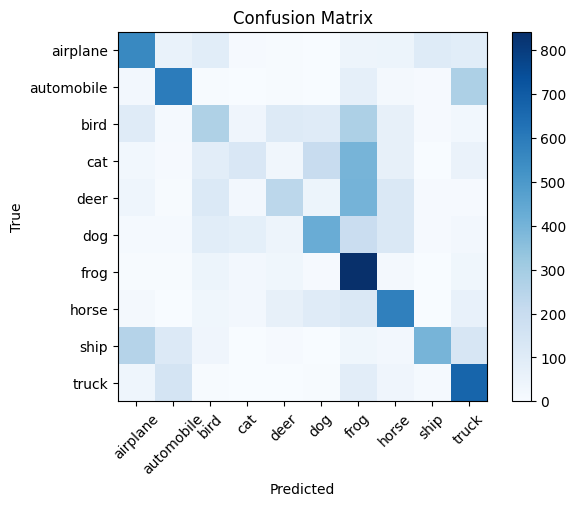

In [127]:
tester_withlabel(args, train_on_gpu, num_workers, batch_size, transform_test, classes, net, criterion)

# Test on no label data

Function to test the model on the professor's test file without labels, and save the predictions to a CSV file.

In [129]:
def tester_nolabel(args, train_on_gpu, num_workers, batch_size, transform_test, net):
    test_data_path = args.test_nolabel_path
    # Loading the test batch without labels using the full path
    test_data = load_cifar_test_nolabels(test_data_path)
    test_dataset = CIFAR10Dataset(test_data, transform=transform_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

    # Ensure the network is in evaluation mode
    net.eval()

    # Predictions list
    predictions = []

    # Iterate over test data
    for batch_idx, data in enumerate(test_loader):
    # Move tensors to GPU if CUDA is available
        if train_on_gpu:
            data = data.cuda()
        output = net(data)
        _, pred = torch.max(output, 1)
        predictions.append(pred.cpu().numpy()) 

        # Concatenate all the predictions into one array
    predictions = np.concatenate(predictions, axis=0)

    # Path to the CSV output file
    output_file = 'submission.csv'

    # Writing to CSV
    with open(output_file, mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['ID', 'Labels'])  # Writing the header
        for idx, label in enumerate(predictions):
            writer.writerow([idx, label])  # Writing each ID and its corresponding label

    print(f"Submission file saved to {output_file}")
    # Save submission.csv to wandb
    wandb.save('submission.csv')
    print("Submission file saved to wandb")

In [130]:
tester_nolabel(args, train_on_gpu, num_workers, batch_size, transform_test, net)

Submission file saved to submission.csv
Submission file saved to wandb
